In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasciencebowl/plankton_identification.pdf
/kaggle/input/datasciencebowl/train.zip
/kaggle/input/datasciencebowl/sampleSubmission.csv.zip
/kaggle/input/datasciencebowl/test.zip


In [3]:
!unzip -q -o /kaggle/input/datasciencebowl/train.zip
!unzip -q -o /kaggle/input/datasciencebowl/test.zip

In [4]:
import glob
train=pd.DataFrame({'path':glob.glob("/kaggle/working/train/*/*")})
pd.options.display.max_colwidth=200
train

,path
0,/kaggle/working/train/amphipods/109887.jpg
1,/kaggle/working/train/amphipods/30718.jpg
2,/kaggle/working/train/amphipods/128698.jpg
3,/kaggle/working/train/amphipods/93095.jpg
4,/kaggle/working/train/amphipods/143201.jpg
...,...
30331,/kaggle/working/train/copepod_calanoid_octomoms/87635.jpg
30332,/kaggle/working/train/copepod_calanoid_octomoms/115045.jpg
30333,/kaggle/working/train/copepod_calanoid_octomoms/147394.jpg
30334,/kaggle/working/train/copepod_calanoid_octomoms/122640.jpg


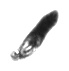

In [5]:
from PIL import Image
Image.open('/kaggle/working/train/fish_larvae_medium_body/127195.jpg')

In [6]:
#folder 만들어서 image 넣기 
import cv2
import os
os.makedirs('resized_train',exist_ok=True)
for path in train['path']:
    image=cv2.imread(path)
    image=cv2.resize(image,(256,256))
    label=path.split('/')[-2]
    name=path.split('/')[-1]
    cv2.imwrite('resized_train/'+label+':'+name,image)

In [7]:
train=pd.DataFrame({'path':glob.glob("resized_train/*")})
train

,path
0,resized_train/hydromedusae_solmaris:27446.jpg
1,resized_train/ctenophore_cydippid_tentacles:94168.jpg
2,resized_train/trichodesmium_puff:71362.jpg
3,resized_train/copepod_cyclopoid_oithona_eggs:75261.jpg
4,resized_train/unknown_blobs_and_smudges:140448.jpg
...,...
30331,resized_train/protist_other:5510.jpg
30332,resized_train/chaetognath_sagitta:140597.jpg
30333,resized_train/hydromedusae_narcomedusae:115353.jpg
30334,resized_train/unknown_blobs_and_smudges:71741.jpg


In [8]:
train['label']=train['path'].apply(lambda x:x.split('/')[-1].split(':')[0])
train

,path,label
0,resized_train/hydromedusae_solmaris:27446.jpg,hydromedusae_solmaris
1,resized_train/ctenophore_cydippid_tentacles:94168.jpg,ctenophore_cydippid_tentacles
2,resized_train/trichodesmium_puff:71362.jpg,trichodesmium_puff
3,resized_train/copepod_cyclopoid_oithona_eggs:75261.jpg,copepod_cyclopoid_oithona_eggs
4,resized_train/unknown_blobs_and_smudges:140448.jpg,unknown_blobs_and_smudges
...,...,...
30331,resized_train/protist_other:5510.jpg,protist_other
30332,resized_train/chaetognath_sagitta:140597.jpg,chaetognath_sagitta
30333,resized_train/hydromedusae_narcomedusae:115353.jpg,hydromedusae_narcomedusae
30334,resized_train/unknown_blobs_and_smudges:71741.jpg,unknown_blobs_and_smudges


In [13]:
from sklearn.model_selection import train_test_split
#x_train 이랑 x_valid 만 넣는 이유는 train_generator 가 알아서 y 값을 넣어야줘야한다 

#stratify
x_train,x_valid=train_test_split(train,test_size=0.2,stratify=train['label'],random_state=42)
train['label']=train['label'].astype(str)


from tensorflow.keras.preprocessing.image import ImageDataGenerator
idg=ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


#idg 에 train 에 만 넣어도
idg2=ImageDataGenerator()

train_generator=idg.flow_from_dataframe(x_train,x_col='path',y_col='label')
valid_generator=idg2.flow_from_dataframe(x_valid,x_col='path',y_col='label')

Found 24268 validated image filenames belonging to 121 classes.
Found 6068 validated image filenames belonging to 121 classes.


In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
model = Sequential()
model.add(EfficientNetB1(include_top=False, pooling='avg'))
model.add(Dense(121, activation='softmax'))  
model.compile(metrics=['acc'], optimizer='adam', loss='categorical_crossentropy')


27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

# Add the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

# Fit the model using both the training and validation generators
model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    callbacks=[early_stopping]  # Include the EarlyStopping callback here
)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1710207620.030576     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710207620.170259     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


619/759 ━━━━━━━━━━━━━━━━━━━━ 1:17 554ms/step - acc: 0.4623 - loss: 2.1655

W0000 00:00:1710207962.667176     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


759/759 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - acc: 0.4792 - loss: 2.0653

ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 120), output.shape=(None, 121)